In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from collections import OrderedDict
#from pytorch_transformers import BertTokenizer, BertConfig
#from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch
import logging
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import nltk
import torch.optim as optim

In [ ]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install sacremoses

     |████████████████████████████████| 890kB 9.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2d590b290b33f11b9812f4666fff6858925e156840f2caf8956819bcc1b1b972
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
pip install boto3

     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 7.2MB 13.8MB/s 
     |████████████████████████████████| 143kB 58.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import sys
import os
sys.path.append(os.path.abspath('/content/drive/My Drive/Colab Notebooks'))


In [ ]:
from __future__ import absolute_import, division, print_function
import pdb
import argparse
import glob
import logging
import os
import pickle
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
#from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
from collections import defaultdict
# from azure.cosmosdb.table.tableservice import TableService
# from azure.cosmosdb.table.models import Entity
from datetime import datetime
import sys
import json
import nltk
nltk.download('punkt')

sys.path.append('../../')
from pytorch_transformers import (WEIGHTS_NAME, AdamW, WarmupLinearSchedule,
                                  BertConfig, BertForLatentConnector, BertTokenizer,
                                  GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer,
                                  OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                                  RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)
from utils import (TextDataset_Split, TextDataset_2Tokenizers_LCtrlG,
                   frange_cycle_linear, frange_cycle_zero_linear, AverageValueMeter)
# from modules import ARAE
from modules import CARA
# logging.getLogger("azure").setLevel(logging.WARNING)
# logging.getLogger("TableService").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)
import time
def get_time_str():
    return time.ctime().replace(' ', '_').replace(':', '-')

# logging.getLogger("azure").setLevel(logging.WARNING)
# logging.getLogger("TableService").setLevel(logging.WARNING)

logger = logging.getLogger(__name__)


MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)
}

    
import modules

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:

encoder_model_type = 'bert'
encoder_model_name = 'bert-base-cased'
decoder_model_type= 'gpt2'
decoder_model_name = 'gpt2'

def mask_tokens(inputs, tokenizer, args):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)

    masked_indices = torch.bernoulli(torch.full(labels.shape, args.mlm_probability)).to(torch.uint8)
    labels[masked_indices==1] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).to(torch.uint8) & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).to(torch.uint8) & masked_indices & ~indices_replaced
    indices_random = indices_random
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [ ]:
pip install transformers

     |████████████████████████████████| 1.8MB 5.2MB/s 
     |████████████████████████████████| 2.9MB 53.6MB/s 
     |████████████████████████████████| 133kB 62.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.3
    Uninstalling urllib3-1.26.3:
      Successfully uninstalled urllib3-1.26.3


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[encoder_model_type]
encoder_config = encoder_config_class.from_pretrained(encoder_model_name)
model_encoder = encoder_model_class.from_pretrained(encoder_model_name, from_tf=bool('.ckpt' in encoder_model_name), config=encoder_config, latent_size=32)
tokenizer_encoder = encoder_tokentokenizer_encoder = encoder_tokenizer_class.from_pretrained(encoder_model_name)
decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[decoder_model_type]
decoder_config = decoder_config_class.from_pretrained(decoder_model_name)
tokenizer_decoder = decoder_tokenizer_class.from_pretrained(decoder_model_name)
model_decoder = decoder_model_class.from_pretrained(decoder_model_name, from_tf=bool('.ckpt' in decoder_model_name), config=decoder_config, latent_size=32, latent_as_gpt_emb=True, latent_as_gpt_memory=True)

100%|██████████| 548118077/548118077 [00:25<00:00, 21498523.45B/s]


In [ ]:
from transformers import GPT2Tokenizer
tokenizer_decoder2 = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
print('We have added', num_added_toks, 'tokens to GPT2', 'total length = ', len(tokenizer_decoder))
model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
assert tokenizer_decoder.pad_token == '<PAD>'

num_added_toks = tokenizer_decoder2.add_special_tokens(special_tokens_dict)
print('We have added', num_added_toks, 'tokens to GPT2', 'total length = ', len(tokenizer_decoder2))
model_decoder.resize_token_embeddings(len(tokenizer_decoder2))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
assert tokenizer_decoder.pad_token == '<PAD>'

We have added 3 tokens to GPT2 total length =  50260
We have added 3 tokens to GPT2 total length =  50260


In [ ]:
import importlib
import imp
#import modules
#import modules
importlib.reload(modules)

class ARGS():
    def __init__(self): # 
        self.encoder_model_type = 'bert'
        self.encoder_model_name = 'bert-base-cased'
        self.decoder_model_type= 'gpt2'
        self.decoder_model_name = 'gpt2'
        self.beta = 0.5
        self.latent_size = 32
        self.device = "cpu"
        self.fb_mode = 0
        self.length_weighted_loss = True 
        self.label_size = 5
        self.mlm_probability = 0.15
        
args = ARGS()
#model_vae = modules.CARA(model_encoder, model_decoder, tokenizer_encoder, tokenizer_decoder, args)

In [ ]:
a = torch.load("/content/drive/My Drive/Optimus/NLP/checkpoint-508523/checkpoint-full-508523/training.bin", map_location='cpu')
#model_vae.load_state_dict(a['model_state_dict'], strict = False)

In [ ]:
polarity = torch.load("/content/drive/My Drive/Optimus/NLP/polarity.pth", map_location='cpu')
id_tokens = torch.load("/content/drive/My Drive/Optimus/NLP/id_tokens.pth", map_location='cpu')
id_tokens_decoder = torch.load("/content/drive/My Drive/Optimus/NLP/id_tokens_decoder.pth", map_location='cpu')

In [ ]:
def pad_sents(sents1, sents2, pad_token1, pad_token2):
    """ Pad list of sentences according to the longest sentence in the batch.
        The paddings should be at the end of each sentence.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded1 = sents1.copy()
    sents_padded2 = sents2.copy()
    max_length = 0
    for i in range(len(sents1)):
        if len(sents1[i]) > max_length:
            max_length = len(sents1[i]) 
  
    for i in range(len(sents2)):
        if len(sents2[i]) > max_length:
            max_length = len(sents2[i]) 

    for i in range(len(sents1)):
        for k in range(len(sents_padded1[i]),max_length):
            sents_padded1[i].append(pad_token1)

    for i in range(len(sents2)):
        for k in range(len(sents_padded2[i]),max_length):
            sents_padded2[i].append(pad_token2)

    ### END YOUR CODE

    return sents_padded1, sents_padded2 



In [ ]:
padded_input_tokens, padded_output_tokens = pad_sents(id_tokens,id_tokens_decoder, 0, tokenizer_decoder.pad_token_id)
tokenized_text0 = torch.tensor(padded_input_tokens)
tokenized_text1 = torch.tensor(padded_output_tokens)

input_seq_ids, tgt_seq_ids = mask_tokens(tokenized_text0, tokenizer_encoder, args)
labels = tokenized_text1
attention_mask=(input_seq_ids > 0).float() # confirm whether attention mask should be with inputs or tokenized_text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


In [ ]:
import importlib
import imp
#import modules
#import modules
importlib.reload(modules)

class ARGS():
    def __init__(self): # 
        self.encoder_model_type = 'bert'
        self.encoder_model_name = 'bert-base-cased'
        self.decoder_model_type= 'gpt2'
        self.decoder_model_name = 'gpt2'
        self.beta = 0.5
        self.latent_size = 32
        self.device = "cuda"
        self.fb_mode = 0
        self.length_weighted_loss = True 
        self.label_size = 5
        self.beta_cls = 1
        self.mlm_probability = 0.15
        #self.training = False
        self.training = False
        self.block_size = 52
        self.temperature = 1
        self.top_k = 3
        self.top_p = 0

args = ARGS()
model_vae = modules.CARA(model_encoder, model_decoder, tokenizer_encoder, tokenizer_decoder, args)


a = torch.load("/content/drive/My Drive/Optimus/NLP/checkpoint-508523/checkpoint_beta_0_1.pth", map_location='cpu')
model_vae.load_state_dict(a, strict = False)
del a
#a = torch.load("/content/drive/My Drive/Optimus/NLP/checkpoint-508523/checkpoint-full-508523/training.bin", map_location='cpu')

#r = model_vae(input_seq_ids=input_seq_ids[3:5], tgt_seq_ids=labels[3:5], cond_labels=torch.tensor(polarity).squeeze()[3:5], attention_mask=attention_mask[3:5])

In [ ]:
model_vae.load_state_dict(a['model_state_dict'], strict = False)

_IncompatibleKeys(missing_keys=['linear.weight', 'label_embedding.weight', 'latent_generator.weight', 'latent_generator.bias', 'latent_classifier.linear1.weight', 'latent_classifier.linear1.bias', 'latent_classifier.linear2.weight', 'latent_classifier.linear2.bias', 'latent_discriminator.weight', 'latent_discriminator.bias', 'gpt_embeddings.weight', 'conv1.weight', 'conv1.bias', 'classifier.linear1.weight', 'classifier.linear1.bias', 'classifier.linear2.weight', 'classifier.linear2.bias'], unexpected_keys=[])

In [ ]:
del a 

In [ ]:
model_vae.training = False
model_vae = model_vae.to("cuda")
dev = "cuda"
#outputs = model_vae(input_seq_ids=input_seq_ids[13:25].to(dev), tgt_seq_ids=labels[13:25].to(dev), cond_labels=aspects_tensor.squeeze()[13:25].to(dev), attention_mask=attention_mask[13:25].to(dev))

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
        {'params': [p for n, p in model_vae.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5,eps=1e-8)

#input_seq_ids = input_seq_ids.to('cuda')
#labels = labels.to('cuda')
#model_vae.to('cuda')

In [ ]:
len(optimizer_grouped_parameters[0]['params'])

203

Training


In [ ]:
tokens_tensor = tokenized_text0
input_seq_ids, tgt_seq_ids = mask_tokens(tokenized_text0, tokenizer_encoder, args)
labels = tokenized_text1
model_vae.to('cuda')
polarity_tensor = torch.tensor(polarity).squeeze()
attention_mask = attention_mask.to('cuda')
input_seq_ids = input_seq_ids.to('cuda')
labels = labels.to('cuda')
polarity_tensor = polarity_tensor.to('cuda')
n_epochs = 1
batch_size = 16
n_iter = int(tokenized_text0.size()[0]/batch_size) + 1
beta_t_list = frange_cycle_zero_linear(n_iter, start=0.0, stop=0.5,  n_cycle=1, ratio_increase=0.25, ratio_zero= 0.25)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=n_iter)
loss_val = []
permutation = torch.randperm(tokens_tensor.size()[0]).to('cuda')

for epoch in range(n_epochs):
    start1 = time.time()
    # X is a torch Variable
    #permutation = torch.randperm(tokens_tensor_train.size()[0])
    #avg_loss = 0
    count = 0
    for i in range(0,tokens_tensor.size()[0], batch_size):
        start = time.time()
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_input_seq_ids, batch_tgt_seq_ids, batch_cond_labels, batch_attention = input_seq_ids[indices], labels[indices], polarity_tensor[indices], attention_mask[indices] 
        beta_t = beta_t_list[count]
        model_vae.args.beta_cls = beta_t

        #if beta_t == 0.0:
        #  model_vae.args.fb_mode = 0
        #else:
        #  model_vae.args.fb_mode = 1

        #model_vae.args.fb_mode = 2

        loss_dict, acc_dict = model_vae(input_seq_ids=batch_input_seq_ids, tgt_seq_ids=batch_tgt_seq_ids, cond_labels=batch_cond_labels, attention_mask=batch_attention)

        for key, value in loss_dict.items():
          loss_dict[key] = value.mean()
        
        loss = loss_dict['loss']
        loss_val.append(loss.detach())
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        model_vae.zero_grad()
        
        

        if count%50 == 0:
          print((time.time()-start1)/60)
          print(loss_dict.items())
        count = count + 1

    

Loss Values for different training Conditions


In [ ]:
plt.plot(loss_val)

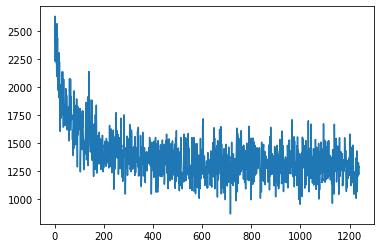

Generate Text


In [ ]:
dev = "cuda"
eos_token_id = tokenizer_decoder2.eos_token_id
bos_token_id = tokenizer_decoder2.bos_token_id
pad_token_id = tokenizer_decoder2.pad_token_id

tokens_tensor = tokenized_text0[:64]
input_seq_ids, tgt_seq_ids = mask_tokens(tokenized_text0, tokenizer_encoder, args)
labels = tokenized_text1[:64]
attention_mask_temp = attention_mask[:64]
#model_test.to(dev)
model_vae2.to(dev)
#aspects_tensor = torch.tensor(aspects).squeeze()
attention_mask = attention_mask.to(dev)
input_seq_ids = input_seq_ids.to(dev)
labels = labels.to(dev)
aspects_tensor = aspects_tensor.to(dev)
n_epochs = 1
batch_size = 4
n_iter = int(tokenized_text0.size()[0]/batch_size) + 1
#beta_t_list = frange_cycle_zero_linear(n_iter, start=0.0, stop=0.5,  n_cycle=1, ratio_increase=0.25, ratio_zero= 0.25)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=n_iter)
loss_val = []
acc_cls_val = []
permutation = torch.randperm(tokens_tensor.size()[0]).to(dev)
accuracy = []
bleu = []

for epoch in range(n_epochs):
    start1 = time.time()
    # X is a torch Variable
    #permutation = torch.randperm(tokens_tensor_train.size()[0])
    #avg_loss = 0
    count = 0
    for i in range(0,tokens_tensor.size()[0], batch_size):
        start = time.time()
        indices = permutation[i:i+batch_size]
        batch_input_seq_ids, batch_tgt_seq_ids, batch_cond_labels, batch_attention = input_seq_ids[indices], labels[indices], aspects_tensor[indices,0].long(), attention_mask[indices] 
        
        with torch.no_grad():
            outputs = model_vae2(input_seq_ids=batch_input_seq_ids, tgt_seq_ids=batch_tgt_seq_ids, cond_labels=batch_cond_labels, attention_mask=batch_attention)

        acc = np.mean(np.array(np.array(outputs['pred_cls'].to('cpu')) == np.array(outputs['cond_labels'].to('cpu')), dtype=np.float))
        acc_ge = np.mean(np.array(np.array(outputs['pred_ge_cls'].to('cpu')) == np.array(outputs['cond_labels'].to('cpu')), dtype=np.float))
        acc_at = np.mean(np.array(np.array(outputs['pred_at_cls'].to('cpu')) == np.array(outputs['sampled_cond_labels'].to('cpu')), dtype=np.float))
        acc_cg = np.mean(np.array(np.array(outputs['pred_cg_cls'].to('cpu')) == np.array(outputs['sampled_cond_labels'].to('cpu')), dtype=np.float))
        accuracy.append(acc)

        generated_ids = []
        generated_text = []
        for g in outputs['generated']:
            if g[0] in [eos_token_id, bos_token_id]:
                g = g[1:]
            if g[0] in [eos_token_id, bos_token_id]:
                g = g[1:]
                
            g = g.tolist()
            g = g[:g.index(eos_token_id)] if eos_token_id in g else g
            g = g[:g.index(pad_token_id)] if pad_token_id in g else g
            g_text = model_vae.tokenizer_decoder.decode(g, clean_up_tokenization_spaces=True)
            generated_ids.append(g)
            generated_text.append(g_text)

        tgt_seq_ids = []
        tgt_seq_text = []
        for g in outputs['tgt_seq_ids']:
            if g[0] in [eos_token_id, bos_token_id]:
                g = g[1:]
            if g[0] in [eos_token_id, bos_token_id]:
                g = g[1:]
            g = g.tolist()
            g = g[:g.index(eos_token_id)] if eos_token_id in g else g
            g = g[:g.index(pad_token_id)] if pad_token_id in g else g
            #g = g[:g.index(0)] if pad_token_id in g else g
            g_text = model_vae.tokenizer_decoder.decode(g, clean_up_tokenization_spaces=True)
            tgt_seq_ids.append(g)
            tgt_seq_text.append(g_text)

        rec_bleu = nltk.translate.bleu_score.corpus_bleu(list_of_references=[[nltk.word_tokenize(t)] for t in tgt_seq_text],
                                                     hypotheses=[nltk.word_tokenize(g) for g in generated_text])
        
        bleu.append(rec_bleu)
        count = count+1
        print(count)
